# SQL Q&A
https://python.langchain.com/docs/tutorials/sql_qa/#agents

In [5]:
# Make sure to set your env varaiable
# export LANGSMITH_API_KEY=[API KEY]

from getpass import getpass
import os

if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass()
    os.environ["LANGSMITH_API_KEY"] = 'true'
# os.environ

    


In [6]:
from langchain_community.utilities import SQLDatabase

from toelo.player_elo.database_connection import get_connection_string, DATABASE_CONFIG


db_uri = get_connection_string(DATABASE_CONFIG)
db = SQLDatabase.from_uri(db_uri)
db.run("SELECT * FROM players_elo LIMIT 5;")


ModuleNotFoundError: No module named 'langchain_community'

In [88]:
from pathlib import Path
from typing_extensions import TypedDict

class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str


from langchain_ollama import ChatOllama

# Chat model
# llm_path = Path.home() / Path("models") / "mistral-7b-openorca.Q4_0.gguf"
llm = ChatOllama(model="llama3.1:8b", n_threads=8)

# https://python.langchain.com/docs/tutorials/sql_qa/#agents

In [89]:
# Provide some instruction
from langchain_core.prompts import ChatPromptTemplate

system_message = system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
    )

for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}

================================ Human Message =================================

Question: {input}


In [90]:
# Populate parameters
from typing_extensions import Annotated

class QueryOutput(TypedDict):
    """Generated SQL query

    Args:
        TypedDict (_type_): _description_
    """
    query: Annotated[str, ...,  "Syntatically valid SQL Query"]
    
def write_query(state: State):
    """Generate SQL query to fetch info

    Args:
        state (State): _description_
    """
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"]
        }
    )
    # print(prompt)
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}



In [91]:
# print(db.dialect)
# print(db.get_table_info())
# print(state["question"])

In [92]:
write_query({"question": "What is the highest elo from players_elo table?"})
write_query({"question" : "How many players exists in our database, you can use Players table"})

{'query': 'SELECT COUNT(*) FROM Players'}

In [93]:
# Execute query
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

def execute_query(state: State):
    """Exectues SQL query

    Args:
        state (State): _description_
    """
    execute_query_tool = QuerySQLDataBaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

# Using like
# execute_query({"query": "SELECT  FROM players_elo LIMIT 5;"})

In [94]:
# Generate answer

def generate_answer(state: State):
    """Answer question using retrieved info as context

    Args:
        state (State): _description_
    """
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer" : response.content}


In [95]:
# Compile into a single graph
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)

graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

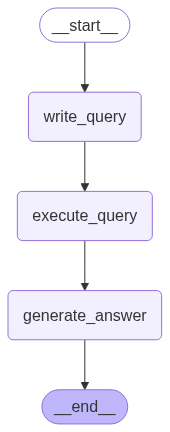

In [96]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [97]:
for step in graph.stream(
    {"question": "How many players exists in our database, you can use Players table"},
    stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) FROM Players'}}
{'execute_query': {'result': '[(32392,)]'}}
{'generate_answer': {'answer': 'The user wants to know how many players exist in the database. \n\nBased on the given SQL query and result, it appears that there are 32,392 players in the database.'}}


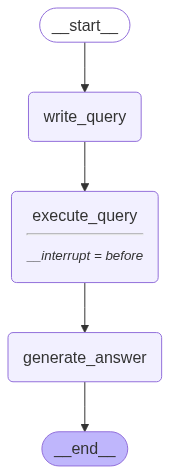

In [ ]:
# Human in loop to check?

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

# Persistence need to specify a thread ID
# So that we can continue the run after review
config: dict[str, dict[str, int]] = {"configurable": {"thread_id": 1}}
display(Image(graph.get_graph().draw_mermaid_png()))

In [99]:
for step in graph.stream(
    {"question": "How many players exists in our database, you can use Players table"},
    config,
    stream_mode="updates",
):
    print(step)
    
try:
    user_approval = input("Do you want to execute query? y/n: ")
except Exception:
    user_approval = "n"
    
if user_approval.lower() == "y":
    # Continue graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation Cancelled by user")

{'write_query': {'query': 'SELECT COUNT(*) FROM Players'}}
{'__interrupt__': ()}
{'execute_query': {'result': '[(32392,)]'}}
{'generate_answer': {'answer': 'There are 32,392 players in your database.'}}


## Agents


In [100]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7454eb6727e0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7454eb6727e0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7454eb6727e0>),
 QuerySQLCheckerTool(description='Use this tool to double check

In [116]:

system_message = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.


Below is the description of tools available.

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

You can use sql_db_list_tables to list all the tables and use sql_db_schema to see the schema and sample rows for those tables.

Then you should query the schema of the most relevant tables.
""".format(
    dialect=db.dialect,
    top_k=5,
)

In [117]:
# Init agent
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, prompt=system_message)


In [118]:
question = "Which player has the highest player elo?"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which player has the highest player elo?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (aa7b765a-7345-4d01-8785-14eef9cfd352)
 Call ID: aa7b765a-7345-4d01-8785-14eef9cfd352
  Args:
    tool_input: 
  sql_db_schema (b7a8cffe-7c73-4f9b-9e27-14a69153ef60)
 Call ID: b7a8cffe-7c73-4f9b-9e27-14a69153ef60
  Args:
    table_names: players
  sql_db_query_checker (244f41e5-67b1-4c54-b1e2-146b284ba613)
 Call ID: 244f41e5-67b1-4c54-b1e2-146b284ba613
  Args:
    query: SELECT * FROM players ORDER BY player_elo DESC LIMIT 1
  sql_db_query (a357c5a2-74c5-4239-b84f-fbbc5991049d)
 Call ID: a357c5a2-74c5-4239-b84f-fbbc5991049d
  Args:
    query: SELECT * FROM players ORDER BY player_elo DESC LIMIT 1
================================= Tool Message =================================
Name: sql_db_query

Error: (psycopg2.errors.UndefinedColumn) column "player_el

In [110]:
from typing import Literal
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")

# Create a predetermined tool call

In [111]:


# Example: create a predetermined tool call
def list_tables(state: MessagesState):
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": "abc123",
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}


# Example: force a model to create a tool call
def call_get_schema(state: MessagesState):
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
    dialect=db.dialect,
    top_k=5,
)


def generate_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = llm.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}


check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)


def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}

In [112]:
def should_continue(state: MessagesState) -> Literal[END, "check_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "check_query"


builder = StateGraph(MessagesState)
builder.add_node(list_tables)
builder.add_node(call_get_schema)
builder.add_node(get_schema_node, "get_schema")
builder.add_node(generate_query)
builder.add_node(check_query)
builder.add_node(run_query_node, "run_query")

builder.add_edge(START, "list_tables")
builder.add_edge("list_tables", "call_get_schema")
builder.add_edge("call_get_schema", "get_schema")
builder.add_edge("get_schema", "generate_query")
builder.add_conditional_edges(
    "generate_query",
    should_continue,
)
builder.add_edge("check_query", "run_query")
builder.add_edge("run_query", "generate_query")

agent = builder.compile()

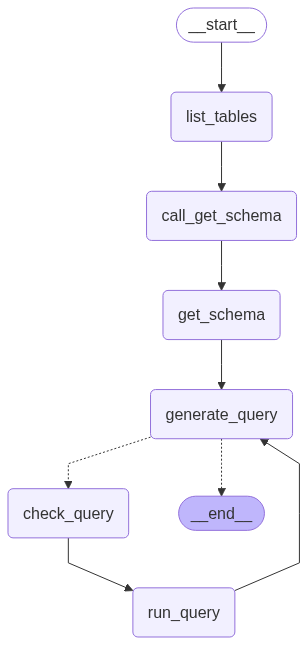

In [113]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(agent.get_graph().draw_mermaid_png()))

In [115]:
question = "Get a country where players from that country has the highest average elo, elo is stored in a table called players_elo"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Get a country where players from that country has the highest average elo, elo is stored in a table called players_elo
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (c66ba963-edc0-4749-aaa7-0747bb7723e1)
 Call ID: c66ba963-edc0-4749-aaa7-0747bb7723e1
  Args:
    tool_input: 
  sql_db_schema (4c01c448-3146-47a5-850c-a90e9e607e3b)
 Call ID: 4c01c448-3146-47a5-850c-a90e9e607e3b
  Args:
    table_names: players_elo
  sql_db_query_checker (7e992a71-a9fa-4298-bdb1-6e8ff3239d79)
 Call ID: 7e992a71-a9fa-4298-bdb1-6e8ff3239d79
  Args:
    query: SELECT country FROM players GROUP BY country ORDER BY AVG(elo) DESC LIMIT 1
  sql_db_query (1a434d7f-c08b-4c2b-b631-b10fd8c65220)
 Call ID: 1a434d7f-c08b-4c2b-b631-b10fd8c65220
  Args:
    query: SELECT country FROM players GROUP BY country ORDER BY AVG(elo) DESC LIMIT 1
================================= T

KeyboardInterrupt: 